**Tutorial 3 - Measuring a Spectral Line by Bayesian Parameter Estimation**

In this tutorial you will measure the strength and width of a spectral line 
using a Bayesian method.


1) Read in the data from the file tut_03_data.csv.  There are three 
columns: wavelength, flux and sigma.  Sigma is the known standard deviation 
of the flux in each pixel.  Plot the spectrum using matplotlib.pyplot.errorbar().

   Unnamed: 0      flux  sigma  wavelength
0           0 -0.071036    0.1         0.0
1           1  0.078741    0.1         1.5
2           2 -0.055522    0.1         3.0
3           3  0.174301    0.1         4.5
4           4 -0.171562    0.1         6.0


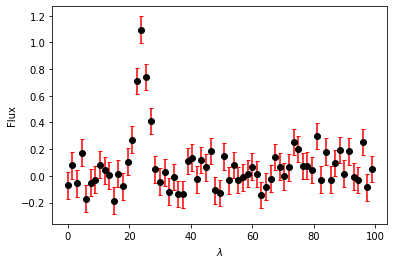

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import seaborn as sn

import scipy.integrate as spi

df = pd.read_csv('tut_03_data.csv')
print(df.head())

flux=np.array(df['flux'])
sigma=np.array(df['sigma'])
wl =np.array(df['wavelength'])

plt.errorbar(wl,flux,yerr=sigma,ecolor='red',capsize=2, fmt='o', color='black')
plt.xlabel(r'$\lambda$')
plt.ylabel('Flux')
plt.show()

2) First we need to subtract off the continuum. We know that there is a line centred around $\lambda \simeq 23$.  Take the part of the spectrum with $\lambda > 45$ which should just be background.  Assume the noise is Gaussian and uncorrelated.   Using a uniform prior on the background.

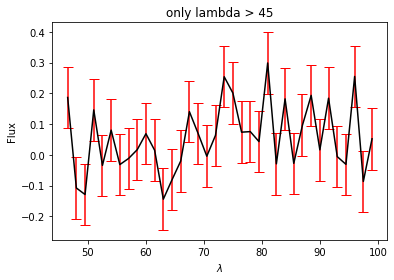

In [16]:
import scipy.optimize as opt

## Separate out the background dominated region of the spectrum, 
##  wavelength > 45,  Make vectors of the flux, wavelength and 
## sigma for these pixels.

df_bk_pixels = df[df['wavelength']>45]

flu = df_bk_pixels['flux']
sig = df_bk_pixels['sigma']
wavel = df_bk_pixels['wavelength']

plt.errorbar(wavel,flu, yerr=sig,ecolor='red',capsize=5, 
color='black')
plt.title('only lambda > 45')
plt.xlabel(r'$\lambda$')
plt.ylabel('Flux')
plt.show()

(250,)
(250,)


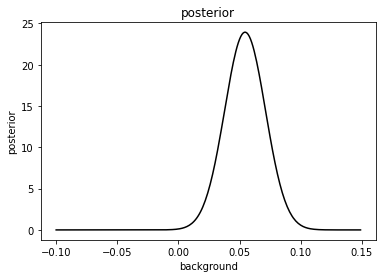

Posterior at edges of parameter space:  5.145873718776109e-18 2.527020085934533e-06
Optimization terminated successfully.
         Current function value: 22.314737
         Iterations: 16
         Function evaluations: 32
The maximum likelihood background is : [0.0545]

The average of posterior  : 3.9999999999999996

The standard deviation of the posterior  : 1.0427503599720536

the result of the integral is  0.9999999999999998


In [17]:



## Make a function that takes the background level b and 
## returns the log-likelihood calculated from the data 
## in the vectors above.  The pixels are statistically independent.
## You can use the df_bk_pixels dataframe made above inside the function
## you define.

def loglike(b): #calculated over all the data, not only lambda > 45 !!
    log_like = -0.5* np.sum(((flu-b)/sig)**2)
    return log_like

## Make an array of possible background values.  Call 
## it "background".

db = 0.001 ## resolution in background
background = np.arange(-0.1,0.15,db)


## To find the right range it is sometimes useful to 
## plot the log-likelihood over different ranges until 
## you find the maximum and you are sure the likelihood 
## is zero at both edges of the range.


## Calculate the likelihood at each of these background values
## using the function you have made.

likelihood = np.zeros(len(background))

for i,b in enumerate(background) :
    likelihood[i]=np.exp(loglike(b))

## Normalize this numerically by summing the  
## likelihood array to get the posterior distribution 
## for the background.
## You should look at the plot and make sure that
## the sum is a good approximation of the integral, i.e. 
## the spacing in the parameter is small enough to make the 
## curve smooth and the range is large enough.



#the posterior i just the likelihood
posterior=likelihood/np.sum(likelihood)/db

print(posterior.shape)
print(background.shape)




## plot posterior for background normalized numerically.
## Its integral should be 1.


plt.plot(background, posterior, color='black')
plt.xlabel('background')
plt.ylabel('posterior')
plt.title('posterior')
plt.show()

print('Posterior at edges of parameter space: ',posterior[0],posterior[-1])

## Find maximum of posterior and the variance numerically.  
## Use opt.fmin()
## The integrals can be made into sums.

bmax=opt.fmin(lambda x: -loglike(x),0)
print('The maximum likelihood background is :',bmax)
print()

bave=np.sum(posterior)/(len(posterior))
print('The average of posterior  :',bave)
print()

#variance=np.sum(posterior*(background-bave)**2)
variance=np.sum(posterior**2 /(background-bave)**2)*db
print('The standard deviation of the posterior  :',np.sqrt(variance))



result = np.sum(posterior*db)
print()
#print('Result of the integral is ', result)


#this is an inefficient way to clacuate the integral but is easier to understand
integral=0
for k in range(len(posterior)):
    integral += posterior[k]*db

print('the result of the integral is ',integral)




3) Now lets fit the line.  Assume the line has the profile

$ f(\lambda) = A \exp\left[- \left( \frac{(\lambda - \lambda_o)}{\Delta\lambda }\right)^2 \right] $

We want to find the parameters $A$, $\lambda_o$, $\Delta\lambda$ and the background.  

In [18]:
import sys


## Write a function for the line profile that takes 
## the wavelength, A, center of line, lo, and the width 
## of the line dl.
def line_profile(l,A,lo,dl):
    profile = A*np.exp(-((l-lo)/dl)**2)
    return profile

## Write a function that takes the parameters 
## A,lo,dl,b and returns the log-likelihood for 
## the data.  The function should have the signature 
## def loglike(p): where p[0]=A, p[1]=lo, p[2]=dl and p[3]=b
## You should use the original dataframe for the data with 
## the full range of wavelength.
def loglike(p):
    if(p[2] <= 0):
        return sys.float_info.max
    else: #fulx -background-line profile
        log_like = 0.5*np.sum(((flux-p[3]-line_profile(wl,p[0],p[1],p[2]))/sigma )**2)
    return log_like
    
## Find the maximum likelihood values for the parameters using 
## the whole data set.  Use the library function 
## scipy.optimize.minimize() to do this. Note that what  
## this function returns is a structure with more than just the solution.
## Read the documentation for this function before starting.  You will
## need to make a guess to start the minimization.  Make these 
## guesses from the plot of the data.  



#guess = (Amplitude, lambda_0, dl, background)
guess = np.array([1.1,25,5,0.05])

maxlikelihood=opt.minimize(loglike,guess)

#print('maximum likelihood solution : ',maxlikelihood)
# .x to plot only the array with the solution

x = maxlikelihood.x

print('maximum likelihood solution : ',maxlikelihood.x)
print('max likelihood for A', x[0])
print('max likelihood for lo',x[1])
print('max likelihood for dl', x[2])
print('max likelihood for b', x[3])

maximum likelihood solution :  [ 1.02866768 24.11716854  2.61398133  0.0286165 ]
max likelihood for A 1.0286676812402018
max likelihood for lo 24.117168542527484
max likelihood for dl 2.61398133155027
max likelihood for b 0.028616502961524702


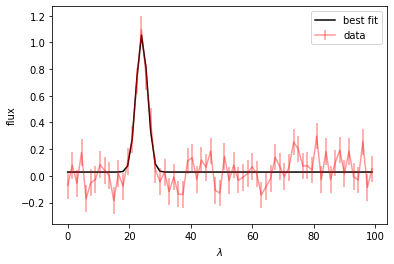

In [19]:
## 4) Plot the best fit model over the plot of the data made in 
## part 1).  Use your line_profile() function.

#x = maxlikelihood.x
#maxlike = (Amplitude, lambda_0, dl, background)

f=x[3]+line_profile(wl,x[0],x[1],x[2]) #background sub + linea
plt.plot(wl,f, color='black',label='best fit')

plt.errorbar(wl,flux,yerr=sigma, color='red', 
label='data',alpha=.4) 

plt.xlabel(r'$\lambda$')
plt.ylabel('flux')

plt.legend()
plt.show()

5) Set all the parameters to their maximum likelihood values except the line strength $A$.  Make a plot of the **conditional posterior** for $A$ near its maximum likelihood value with uniform and Jaffreys priors on $A$.

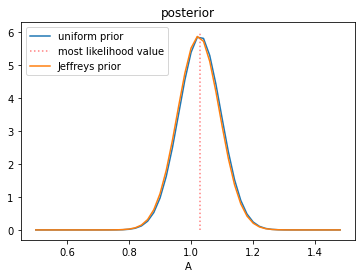

since we are dealing with a large amount od data the choise of prior does not affect the result
the result of the integral for jeff posterior is 1.0000000000000002
the result of the integral for unif posterior is  1.0


In [20]:
#maximum likelihood solution :  [ 1.02866768 24.11716855  2.61398136  0.0286165 ]

ddl = (4-1)/50
dlarray = np.arange(1, 4, ddl)

dA=(1.5-0.5)/50 #resolution for the integral
Aarray = np.arange(0.5,1.5,dA)

unif_posterior = np.empty(len(Aarray))
#UNIFORM POSTERIOR E EXP DI LOGLIKE CHE PRENDE IN PANCIA I VALORI DI LINE PROFILE
#prior = 1/(np.max(Aarray)-np.min(Aarray))
for i,A in enumerate(Aarray):
    unif_posterior[i]=np.exp(-loglike(np.array([A,x[1],x[2],x[3]])))#*prior

## normalize the posterior
unif_posterior /= np.sum(unif_posterior)*dA



plt.plot(Aarray,unif_posterior,label='uniform prior') 



jeff_posterior = np.empty(len(Aarray))
for i,A in enumerate(Aarray):
    jeff_posterior[i]=np.exp(-loglike(np.array([A,x[1],x[2],x[3]])))/A
    
jeff_posterior /= np.sum(jeff_posterior)*dA

#print(jeff_posterior.shape)

plt.vlines(x[0], 0,6, label='most likelihood value', alpha=.5, color='red', linestyle='dotted')
plt.plot(Aarray,jeff_posterior,label='Jeffreys prior')
plt.legend()
plt.title('posterior')
plt.xlabel('A')
plt.show()
print('since we are dealing with a large amount od data the choise of prior does not affect the result')

integral=0
for k in range(len(jeff_posterior)):
    integral += jeff_posterior[k]*dA

print('the result of the integral for jeff posterior is',integral)

integral=0
for k in range(len(unif_posterior)):
    integral += unif_posterior[k]*dA

print('the result of the integral for unif posterior is ',integral)
## Doee the choice of prior change the result significantly?




6) Make a 2D map of the conditional posterior as a function of $A$ and $\Delta \lambda$ at the maximum likelihood values of the other parameters.  Do this by making a grid of $A$ and $\Delta \lambda$ values and using matplotlib.pyplot.contour().  Put the proper labels on the axes.

(50, 50)


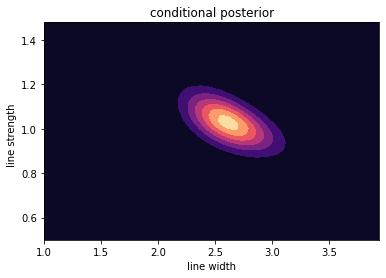

0.9999999999999987


In [21]:


post = np.zeros([len(Aarray),len(dlarray)])

for i,A in enumerate(Aarray):
    for j,dl in enumerate(dlarray):
        
        post[i,j] = np.exp(-loglike([A,x[1],dl,x[3]]))


#post /= np.sum(post)
## this is very useful for making 2D plots. X and Y are 2D arrays.
#X, Y = np.meshgrid(dlarray, Aarray)
print(post.shape)
#print(X.shape)
#print(Y.shape)

post=post/np.sum(post)/ddl/dA

plt.contourf(dlarray,Aarray,post, cmap='magma')
plt.xlabel('line width')
plt.ylabel('line strength  ')
plt.title("conditional posterior")

plt.show()

integral = 0
for k in range(len(Aarray)):
    for l in range(len(dlarray)):
    
        integral += post[k,l] *dA *ddl

print(integral)



7) Write a function that takes values for $A$ and $\Delta \lambda$ and returns the 
posterior **marginalized** over $\lambda_o$.  Use scipy.integrate.quad() to do the 
integration.  You will need to make a new "posterior" function with the correct 
order of input parameters to use this function.  Use the maximum likelihood value for the background from part 2).  You might want to reduce the resolution of the grid to reduce the run time.

(50, 50)


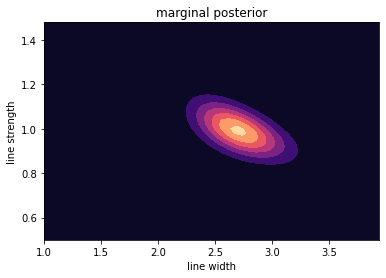

the value of the integral is: 0.9999999999999992


In [22]:
#from scipy.integrate import quad
#guess = (Amplitude, lambda_0, dl, background)

bmax = x[3]

# this reorders the parameters
#we integrate over l0
def posterior1(lo,A,dl,b):
    return np.exp(-loglike(np.array([A,lo,dl,b])))
    #def loglike(A,lo,dl,b):

def marginal_posterior(A,dl):
    result, errr = spi.quad(posterior1, 0.,30., args=(A, dl, bmax))
    return result
    ## use quad to integrate over lo only using the arg option

#Aarray = np.arange(0.65,1.4,dA)
#dlarray = np.arange(2, 3, ddl)
post = np.zeros([len(Aarray),len(dlarray)])

for i,A in enumerate(Aarray):
    for j,dl in enumerate(dlarray):
        
        post[i,j] = marginal_posterior(A, dl)

#post /= np.sum(post)

## this is very useful for making 2D plots. X and Y are 2D arrays.
X, Y = np.meshgrid(dlarray, Aarray)
print(post.shape)
#print(X.shape)
#print(Y.shape)

post=post/np.sum(post)/ddl/dA

plt.contourf(X,Y,post, cmap='magma')
plt.xlabel('line width')
plt.ylabel('line strength')
plt.title("marginal posterior")


plt.show()

integral = 0
for k in range(len(Aarray)):
    for l in range(len(dlarray)):
    
        integral += post[k,l] *dA *ddl

print('the value of the integral is:',integral)


8) Sum the 2D array from 7) to find the 1D marginalized posteriors for both 
$\Delta\lambda$ and $A$.  This is a numerical marginalization which can be done by simply summing along each of the axes.  The sum approximates an integral over the parameter.

Plot both marginal distributions.  If these are not smooth, you haven't used enough points in parameter space.

the value of the integral for A is 1.0000000000000002


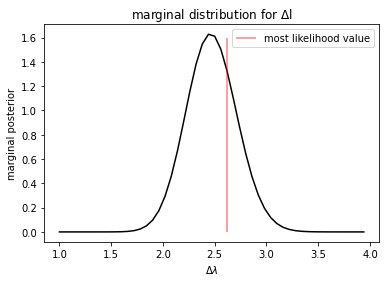

the value of the integral for A is 0.9999999999999999


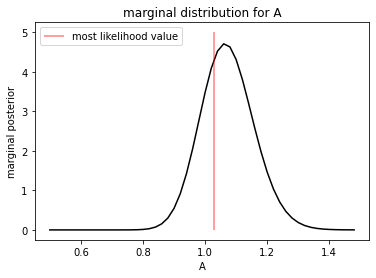

In [23]:
post_dl=np.sum(post,axis=(1))
post_dl /= np.sum(post_dl*ddl)

#print('is normalized?',np.sum(post_dl*ddl))
integral= 0
for k in range(len(post_dl)):
    integral += post_dl[k] * ddl 
print('the value of the integral for A is',integral)

plt.plot(dlarray,post_dl, color='black')
plt.vlines(x[2],0,1.6, label='most likelihood value', color='red', 
alpha=.5)
plt.xlabel("$\Delta\lambda$")

plt.title('marginal distribution for $\Delta$l')
plt.ylabel('marginal posterior')
plt.legend()
plt.show()

post_A=np.sum(post,axis=(0))


post_A /= np.sum(post_A*dA)

integral= 0
for k in range(len(post_A)):
    integral += post_A[k] * dA 
print('the value of the integral for A is',integral)

plt.plot(Aarray,post_A, color='black')
plt.vlines(x[0],0,5, label='most likelihood value', color='red', 
alpha=.5)
plt.xlabel("A")
plt.ylabel('marginal posterior')
plt.title('marginal distribution for A')
plt.legend()
plt.show()




9) Find the mean and variance for $\Delta\lambda$ and the $A$ using the map of the marginalized posterior found above, the X and Y arrays from above, and the numpy.sum() function.  Each of these will be marginalized over all other variables except the background.  Do the integrals by simply summing in the appropriate dimensions.

In [24]:
#Aarray da 0.5 a 1.5 --> Y
# #dlarray da 1 a 4 --> X


mean =0
for i in range(len(post_A)):
    mean += post_A[i]*dA*Aarray[i]
print('the mean for A is',mean)

var =0
for i in range(len(Aarray)):
    var += (Aarray[i]-mean)**2 *dA *post_A[i]
print('the var for A is',var)


mean1 =0
for i in range(len(post_A)):
    mean1 += post_dl[i]*ddl*dlarray[i]
print('the mean for dl is ',mean1)

var =0
for i in range(len(Aarray)):
    var += (dlarray[i]-mean1)**2 *ddl *post_dl[i]
print('the var for dl is',var)




the mean for A is 1.07274214578281
the var for A is 0.007334596501887934
the mean for dl is  2.471549588981771
the var for dl is 0.059965727183881386


In [25]:
#########################################
#  This function finds the level for a contour that contains 
#  a fixed fraction of the total sum of pixels (or voxels).
#  Understand it. Run this box so that it is defined
#########################################




def find_level(posterior,fraction) :
    tot = np.sum(posterior)  #tot value in case of not normalized posterior bho
    max = np.max(posterior)
    min = np.min(posterior)

    ## initialize level to halfway between max and min
    level = 0.5*(max + min) 
    ## initialize fraction for this level
    frac = np.sum( posterior[ posterior >= level ]  )/tot
    ## initialize resolution = +/- smallest pixel as fraction of total
    res = np.min( posterior[ posterior >= level ]  )/tot

    ## iterate until frac is within res of the input fraction
    while( abs(frac - fraction) > res  ) :
        
        ## update max or min
        if( frac > fraction) :
            min = level
        else :
            max = level
        
        ## update level by bisecting 
        level = 0.5*(max + min)
        
        ## update frac and res    
        frac = np.sum( posterior[ posterior >= level ] )/tot
        res = np.min( posterior[ posterior >= level ]  )/tot

    ## output the level and its actual fraction
    return level,frac

###

c68_A = find_level(post_A,0.68)
c68_dl = find_level(post_dl, 0.68)

print(c68_A, c68_dl)

c95_A = find_level(post_A, 0.95)
c95_dl = find_level(post_dl, 0.95)

print(c95_A, c95_dl)

(2.9423271901251353, 0.654928763849113) (1.017203678697104, 0.6748886423473758)
(0.5884654380252737, 0.9532980361623589) (0.2034407361211859, 0.9506228632614545)


10) Using the function above, find the 68% and 95% confidence regions for $A$ and $\Delta\lambda$ and make a 2D contour plot of these levels.

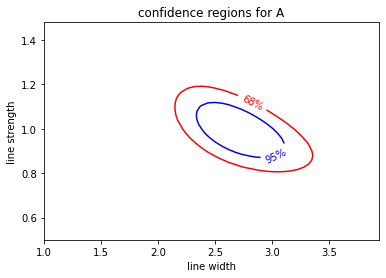

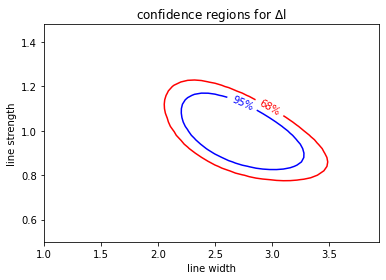

In [26]:
h = plt.contour(X,Y, post, [c95_A[0],c68_A[0]],colors=['red','blue'])
plt.xlabel('line width')
plt.ylabel('line strength')
plt.title('confidence regions for A')



fmt = {}
strs = ['68%', '95%']
for l, s in zip(h.levels, strs):
    fmt[l] = s

# Label every other level using strings
plt.clabel(h, h.levels[::1], inline=True, fmt=fmt, fontsize=10)




plt.show()

e = plt.contour(X,Y, post, [c95_dl[0],c68_dl[0]],colors=['red','blue'])
plt.xlabel('line width')
plt.ylabel('line strength')
plt.title('confidence regions for $\Delta$l')

fmt = {}
strs = ['68%', '95%']
for l, s in zip(e.levels, strs):
    fmt[l] = s

# Label every other level using strings
plt.clabel(e, e.levels[::1], inline=True, fmt=fmt, fontsize=10)


plt.show()
